In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import requests
import seaborn as sns
import json

# %matplotlib qt

In [28]:
# Set seaborn theme
sns.set_theme()

# Get data

Read your personal API key

In [29]:
with open("../api_key", "r") as file:
    API_KEY = file.read()

In [30]:
# Define the API endpoint and parameters
url = "https://api.atmo-aura.fr/api/v1/valeurs/horaire"

data = pd.DataFrame()

for site_id in ["FR15038", "FR15043", "FR15053"]:
    params = {
        "api_token": API_KEY,
        "format": "json",
        "sites": site_id,
        "date_debut": "-2 years",
        "label_court_polluant": "PM2.5",
        "order_by_date": "asc",
    }

    # Make the GET request
    response = requests.get(url, params=params)

    response = json.loads(response.text)
    data = pd.concat([data, pd.DataFrame(response["data"])], ignore_index=True)

    while response["links"]["next"] is not None:
        response = requests.get(response["links"]["next"])
        response = json.loads(response.text)
        data = pd.concat([data, pd.DataFrame(response["data"])], ignore_index=True)

data["date"] = pd.to_datetime(data["date"])
data["date"] = data["date"].dt.tz_localize(None)

In [31]:
class site():
    def __init__(self, data, site_id):
        self.data = data[data["site_id"] == site_id]

        if self.data.empty:
            raise ValueError("No data available for this site")
        
        self.site_id = site_id

        self.reference_data = self.data.query("type_appareil_id == 11")
        self.reference_values = self.reference_data.loc[:, ["valeur", "date"]]

        self.microsensor_data = self.data.query("type_appareil_id == 57")
        self.microsensor_values = self.microsensor_data.loc[:, ["valeur", "date"]]

    def get_reference_data(self):
        return self.reference_data
    
    def get_microsensor_data(self):
        return self.microsensor_data
    
    def get_reference_values(self):
        return self.reference_values
    
    def get_microsensor_values(self):
        return self.microsensor_values
    
    def filter_date(self, start_date, end_date):
        reference = self.get_reference_data()
        microsensor = self.get_microsensor_data()

        reference = reference[(reference["date"] >= start_date) & (reference["date"] <= end_date)]
        microsensor = microsensor[(microsensor["date"] >= start_date) & (microsensor["date"] <= end_date)]

        return reference, microsensor
    
    def plot(self, ax = None, *, kwargs = {}):
        if ax is None:
            ax = plt.gca()

        x_ref = self.reference_values["date"]
        y_ref = self.reference_values["valeur"]

        x_micro = self.microsensor_values["date"]
        y_micro = self.microsensor_values["valeur"]

        ax.plot(x_ref, y_ref, label="Reference values")
        ax.plot(x_micro, y_micro, label="Microsensor values")
        ax.set_title(f"PM2.5 values for site {self.site_id}")
        ax.set_xlabel("Date")
        ax.set_ylabel("PM2.5 values (µg/m³)")
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        ax.legend()
    
        return ax

In [32]:
site_id_dict = {
    "Saint Martin d'Hères": "FR15038",
    "Les Frenes": "FR15043",
    "Rocade Sud": "FR15053",
}

LF = site(data, site_id_dict["Les Frenes"])
SMH = site(data, site_id_dict["Saint Martin d'Hères"])

# Descriptive statistics
On the SMH station

In [33]:
# Filter on date
reference, microsensor = SMH.filter_date("2023-01-01", "2023-12-31")
# Merge microsensor and reference data
smh_data = pd.merge(reference, microsensor, on="date")

In [ ]:
# Compute absolute difference
smh_data["abs_diff"] = abs(smh_data["valeur_x"] - smh_data["valeur_y"])

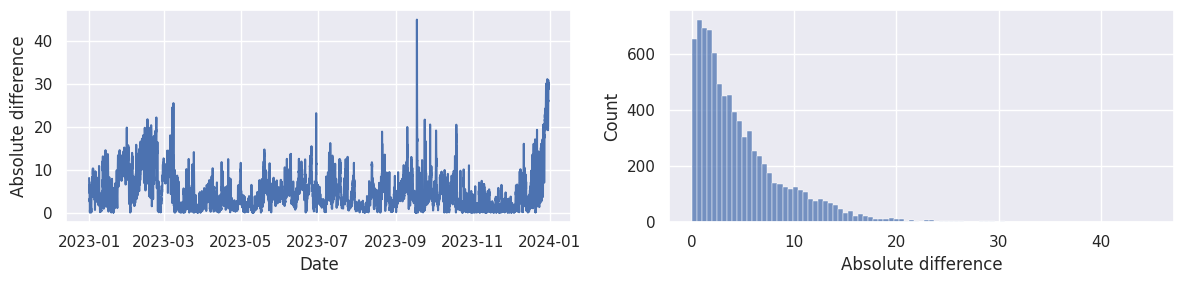

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].plot(smh_data["date"], smh_data["abs_diff"])
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Absolute difference")

sns.histplot(smh_data["abs_diff"], ax=axes[1])
axes[1].set_xlabel("Absolute difference")

plt.tight_layout()
plt.show()
